# Big-Little Matching Notebook
Group members: Zora Mardjoko, Kevin He

In [1]:
from ortools.sat.python import cp_model
import graphviz
from collections import defaultdict
from IPython.display import display
from typing import List, Dict


Explanation of the inputs:

`bigs`, `littles`: dictionaries with participant IDs and max_matches

`big_prefs`, `little_prefs`: ranked lists of preferences for each participant 

`enforce_exactly_one`: if `True`, forces each person to be matched exactly once

`preference_weight`: Controls which preference gets more weight. 0.5 is neutral, can choose to weight the bigs' or littles' preferences more.

Other details: the solver currently assigns `max_rank` to anyone left unranked, which is different for bigs and littles.

In [2]:
class BigLittleMatcher:
    def __init__(self, bigs: Dict, littles: Dict, big_prefs: Dict, little_prefs: Dict):
        self.bigs = bigs
        self.littles = littles
        self.big_prefs = big_prefs
        self.little_prefs = little_prefs
        self.model = cp_model.CpModel()
        self.x = {}
        self.scores = {}
        self.max_rank_b = len(self.littles)
        self.max_rank_l = len(self.bigs)
        self.solver = cp_model.CpSolver()

In [3]:
def build_model(self, preference_weight: float = 0.5, enforce_exactly_one: bool = False):
    #x[(b, l)] is 1 if big b is matched with little l
    for b in self.bigs:
        for l in self.littles:
            self.x[(b, l)] = self.model.NewBoolVar(f"x_{b}_{l}")

    
    for l in self.littles:
        vars_l = [self.x[(b, l)] for b in self.bigs]
        # each little must be matched to exactly one big
        if enforce_exactly_one:
            self.model.Add(sum(vars_l) == 1)
        # there are twins
        else:
            self.model.Add(sum(vars_l) >= 1)
            self.model.Add(sum(vars_l) <= self.littles[l].get('max', 1))

    for b in self.bigs:
        vars_b = [self.x[(b, l)] for l in self.littles]
        # if exact matching
        if enforce_exactly_one:
            self.model.Add(sum(vars_b) == 1)
        # each big must be matched to at least one little
        # and no more than their max
        else:
            self.model.Add(sum(vars_b) >= 1)
            self.model.Add(sum(vars_b) <= self.bigs[b].get('max', 1))

    for b in self.bigs:
        for l in self.littles:
            # lower rank means higher preference
            # assigns max_rank to unranked people
            rank_b = self.big_prefs.get(b, []).index(l) if l in self.big_prefs.get(b, []) else self.max_rank_b
            rank_l = self.little_prefs.get(l, []).index(b) if b in self.little_prefs.get(l, []) else self.max_rank_l

            score = (
                preference_weight * (self.max_rank_b - rank_b)
                + (1 - preference_weight) * (self.max_rank_l - rank_l)
            )
            self.scores[(b, l)] = score

    self.model.Maximize(sum(self.scores[(b, l)] * self.x[(b, l)] for (b, l) in self.x))

BigLittleMatcher.build_model = build_model

In [4]:
def solve(self):
    status = self.solver.Solve(self.model)
    if status != cp_model.OPTIMAL:
        raise ValueError('Not possible!')
    matches = [(b, l) for (b, l), var in self.x.items() if self.solver.Value(var)]
    return matches, self.solver.ObjectiveValue()

BigLittleMatcher.solve = solve

In [5]:
def pretty_print(self):
    print(self.solver.ResponseStats())
    score_achieved = self.solver.ObjectiveValue()
    print(f"Total preference score: {score_achieved:.0f}")
    COLORS = ['aqua', 'coral', 'darkgreen', 'gold', 'darkolivegreen1',
                'deeppink', 'crimson', 'darkorchid', 'bisque', 'yellow']
    G = graphviz.Graph()
    for (b, l), var in self.x.items():
        if self.solver.Value(var):
            G.edge(f'{b}', f'{l}', penwidth=str(self.scores[(b, l)]))
            G.node(f'{b}', color=COLORS[hash(b) % len(COLORS)])
            G.node(f'{l}', color=COLORS[hash(l) % len(COLORS)])
    display(G)

BigLittleMatcher.pretty_print = pretty_print

Basic test case below.

CpSolverResponse summary:
status: OPTIMAL
objective: 8
best_bound: 8
integers: 6
booleans: 9
conflicts: 0
branches: 20
propagations: 52
integer_propagations: 41
restarts: 20
lp_iterations: 0
walltime: 0.0166111
usertime: 0.0166112
deterministic_time: 2.3028e-05
gap_integral: 5.68639e-06
solution_fingerprint: 0x27b8fff9edcd2da2

Total preference score: 8


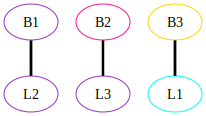

In [6]:
bigs = {
    'B1': {'max': 2},
    'B2': {'max': 1},
    'B3': {'max': 1},
}

littles = {
    'L1': {'max': 1},
    'L2': {'max': 1},
    'L3': {'max': 2},
}

big_prefs = {
    'B1': ['L2', 'L1', 'L3'],
    'B2': ['L3', 'L1', 'L2'],
    'B3': ['L1', 'L2', 'L3']
}

little_prefs = {
    'L1': ['B1', 'B3', 'B2'],
    'L2': ['B2', 'B1', 'B3'],
    'L3': ['B3', 'B1', 'B2']
}



matcher = BigLittleMatcher(bigs, littles, big_prefs, little_prefs)
matcher.build_model(preference_weight=0.75, enforce_exactly_one=True)
soln, obj_value = matcher.solve()
matcher.pretty_print()

What happens if bigs and littles have completely opposite preferences, but `preference_weight` = 0.5?

CpSolverResponse summary:
status: OPTIMAL
objective: 7.5
best_bound: 7.5
integers: 7
booleans: 9
conflicts: 0
branches: 22
propagations: 41
integer_propagations: 43
restarts: 19
lp_iterations: 0
walltime: 0.008223
usertime: 0.0082231
deterministic_time: 2.1498e-05
gap_integral: 1.9824e-06
solution_fingerprint: 0x27b8fff9edcd2da2

Total preference score: 8


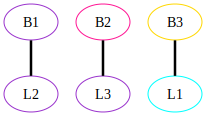

Matches:
  B1 ↔ L2
  B2 ↔ L3
  B3 ↔ L1


In [7]:
bigs = {
    'B1': {'max': 1},
    'B2': {'max': 1},
    'B3': {'max': 1},
}

littles = {
    'L1': {'max': 1},
    'L2': {'max': 1},
    'L3': {'max': 1},
}

big_prefs = {
    'B1': ['L1', 'L2', 'L3'],
    'B2': ['L2', 'L3', 'L1'],
    'B3': ['L3', 'L1', 'L2'],
}

little_prefs = {
    'L1': ['B3', 'B2', 'B1'],  # reverse of B1
    'L2': ['B1', 'B3', 'B2'],  # reverse of B2
    'L3': ['B2', 'B1', 'B3'],  # reverse of B3
}

matcher = BigLittleMatcher(bigs, littles, big_prefs, little_prefs)
matcher.build_model(preference_weight=0.5, enforce_exactly_one=True)
matches, obj_value = matcher.solve()
matcher.pretty_print()
print("Matches:")
for b, l in matches:
    print(f"  {b} ↔ {l}")

Complex test case:

CpSolverResponse summary:
status: OPTIMAL
objective: 47
best_bound: 47
integers: 36
booleans: 36
conflicts: 0
branches: 72
propagations: 180
integer_propagations: 241
restarts: 72
lp_iterations: 9
walltime: 0.0184582
usertime: 0.0184583
deterministic_time: 0.000468518
gap_integral: 0
solution_fingerprint: 0x6dfd2262cd2df959

Total preference score: 47


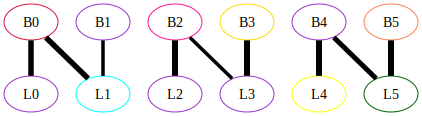

Matches:
  B0 ↔ L0
  B0 ↔ L1
  B1 ↔ L1
  B2 ↔ L2
  B2 ↔ L3
  B3 ↔ L3
  B4 ↔ L4
  B4 ↔ L5
  B5 ↔ L5


In [8]:
bigs = {
    f'B{i}': {'max': 2 if i % 2 == 0 else 1} for i in range(6)
}

littles = {
    f'L{i}': {'max': 1 if i % 2 == 0 else 2} for i in range(6)
}

big_prefs = {
    'B0': ['L0', 'L1', 'L2', 'L3', 'L4', 'L5'],
    'B1': ['L1', 'L0', 'L2', 'L5', 'L4', 'L3'],
    'B2': ['L2', 'L3', 'L0', 'L1', 'L5', 'L4'],
    'B3': ['L3', 'L2', 'L1', 'L0', 'L5', 'L4'],
    'B4': ['L4', 'L5', 'L0', 'L1', 'L2', 'L3'],
    'B5': ['L5', 'L4', 'L3', 'L2', 'L1', 'L0'],
}

little_prefs = {
    'L0': ['B1', 'B0', 'B3', 'B2', 'B5', 'B4'],
    'L1': ['B0', 'B2', 'B4', 'B5', 'B3', 'B1'],
    'L2': ['B2', 'B3', 'B1', 'B0', 'B4', 'B5'],
    'L3': ['B3', 'B4', 'B5', 'B0', 'B2', 'B1'],
    'L4': ['B4', 'B5', 'B0', 'B1', 'B3', 'B2'],
    'L5': ['B5', 'B4', 'B2', 'B3', 'B0', 'B1'],
}

matcher = BigLittleMatcher(bigs, littles, big_prefs, little_prefs)
matcher.build_model(enforce_exactly_one=False)
matches, obj_value = matcher.solve()
matcher.pretty_print()
print("Matches:")
for b, l in matches:
    print(f"  {b} ↔ {l}")